In [3]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
import matplotlib.font_manager as fm
from textwrap import wrap


prop = fm.FontProperties(fname='../plots/arial.ttf')

plt.rcParams['ps.useafm'] = True
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

from statsmodels.stats.multitest import multipletests

import sys
import os

sys.path.append(os.path.relpath("../../huygens"))
sys.path.append(os.path.relpath("../../galileo"))
import galileo as gal
import huygens as huy

import helper

# Load rMATS outputs

In [4]:
with open("experiments.json","r") as f:
    exp = json.load(f)
    
    experiments = exp["experiments"]
    experiment_ids = exp["experiment_ids"]
    display_names = exp["display_names"]
    display_groups = exp["display_groups"]


In [5]:
rpl22_oe_rmats = pd.read_hdf("../data/processed/rmats_merge/rpl22_oe.h5",key="rmats")
rpl22l1_oe_rmats = pd.read_hdf("../data/processed/rmats_merge/rpl22l1_oe.h5",key="rmats")
rpl22l1_kd1_rmats = pd.read_hdf("../data/processed/rmats_merge/rpl22l1_kd1.h5",key="rmats")
rpl22l1_kd2_rmats = pd.read_hdf("../data/processed/rmats_merge/rpl22l1_kd2.h5",key="rmats")
rpl22_a_ko1_rmats = pd.read_hdf("../data/processed/rmats_merge/rpl22_a_ko1.h5",key="rmats")
rpl22_a_ko2_rmats = pd.read_hdf("../data/processed/rmats_merge/rpl22_a_ko2.h5",key="rmats")
rpl22_b_ko1_rmats = pd.read_hdf("../data/processed/rmats_merge/rpl22_b_ko1.h5",key="rmats")
rpl22_b_ko2_rmats = pd.read_hdf("../data/processed/rmats_merge/rpl22_b_ko2.h5",key="rmats")

rpl22_oe_rmats = rpl22_oe_rmats.rename({"PValue":"pval","FDR":"qval"},axis=1)
rpl22l1_oe_rmats = rpl22l1_oe_rmats.rename({"PValue":"pval","FDR":"qval"},axis=1)
rpl22l1_kd1_rmats = rpl22l1_kd1_rmats.rename({"PValue":"pval","FDR":"qval"},axis=1)
rpl22l1_kd2_rmats = rpl22l1_kd2_rmats.rename({"PValue":"pval","FDR":"qval"},axis=1)
rpl22_a_ko1_rmats = rpl22_a_ko1_rmats.rename({"PValue":"pval","FDR":"qval"},axis=1)
rpl22_a_ko2_rmats = rpl22_a_ko2_rmats.rename({"PValue":"pval","FDR":"qval"},axis=1)
rpl22_b_ko1_rmats = rpl22_b_ko1_rmats.rename({"PValue":"pval","FDR":"qval"},axis=1)
rpl22_b_ko2_rmats = rpl22_b_ko2_rmats.rename({"PValue":"pval","FDR":"qval"},axis=1)

splice_types = ["A3SS","A5SS","MXE","RI","SE"]

# Differential splicing

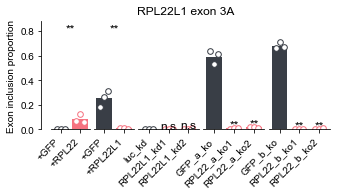

In [6]:
axes = helper.all_bars("RPL22L1_ENSG00000163584_170585801_170585990_170585801_170585923_170586086_170586176", 
     "splicing")
plt.suptitle("RPL22L1 exon 3A")

plt.savefig("../plots/RPL22L1_3A_splicing.pdf",bbox_inches="tight",background="transparent")

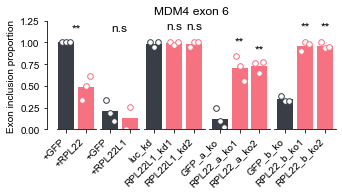

In [7]:
axes = helper.all_bars("MDM4_ENSG00000198625_204506557_204506625_204501318_204501374_204507336_204507436", 
     "splicing")

plt.suptitle("MDM4 exon 6")
plt.savefig("../plots/MDM4_6_splicing.pdf",bbox_inches="tight",background="transparent")

# Splicing types

In [8]:
def plot_splice_types(rmats_diffs, qval_cutoff=0.01, ax=None,legend=False):
    
    if ax is None:
        ax = plt.subplot(111)

    significants = rmats_diffs.copy(
        deep=True)[rmats_diffs["qval"] < qval_cutoff]

    significants["treatment_increase"] = significants["treatment_median"] > significants["control_median"]

    significants["treatment_increase"] = significants["treatment_increase"].replace({True: "Inclusion",
                                                                                     False: "Exclusion"})

    significants = significants.groupby(
        "splice_type")["treatment_increase"].value_counts()
    significants = significants.unstack()

    significants, _ = significants.align(
        pd.Series(index=splice_types), join="right", axis=0)
    significants = significants.fillna(0)

    significants["splice_type"] = significants.index
    
    significants.columns.name = ""
    
    significants.plot(x="splice_type",
                      y=["Exclusion", "Inclusion"],
                      kind="bar",
                      cmap=mpl.colors.ListedColormap(
                          ["#dbe2ef", "#3f72af"]),
                      ax=ax,
                      stacked=True,
                      width=0.8,
                      legend=legend
                      )
    
    plt.ylabel("Frequency")
    plt.xlabel("Splice type")
    
    plt.xticks(rotation=45,ha="right")

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines['left'].set_position(('axes', -0.05))

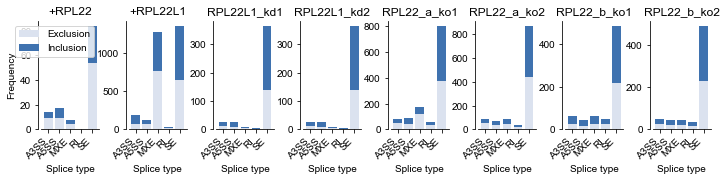

In [11]:
plt.figure(figsize=(12,2))
    
for experiment_idx, experiment in enumerate([rpl22_oe_rmats,
                                             rpl22l1_oe_rmats,
                                             rpl22l1_kd1_rmats,
                                             rpl22l1_kd1_rmats,
                                             rpl22_a_ko1_rmats,
                                             rpl22_a_ko2_rmats,
                                             rpl22_b_ko1_rmats,
                                             rpl22_b_ko2_rmats
                                            ]):

    ax = plt.subplot(1,8,experiment_idx+1)
    plot_splice_types(experiment,ax=ax,legend=experiment_idx<1)
    
    if experiment_idx > 0:
        plt.ylabel("")
        
    ax.set_title(display_names[experiment_idx])
        
plt.subplots_adjust(wspace=0.5)

plt.savefig("../plots/significant_splice_types.pdf",bbox_inches="tight",background="transparent")

# Overlaps

In [56]:
def get_overlaps(diffs,cutoff=0.01, direction=None, entity="exon"):

    significants = []
    
    for diff in diffs:
        
        if direction == None:
        
            significant = diff.copy(deep=True)[diff["qval"]<cutoff]
            
        if direction == "pos":
            
            significant = diff.copy(deep=True)[diff["qval"]<cutoff]
            significant = significant[significant["median_foldchange"]>=1]
            
        elif direction == "neg":
            
            significant = diff.copy(deep=True)[diff["qval"]<cutoff]
            significant = significant[significant["median_foldchange"]<1]
        
        if entity == "gene":
        
            significant_entities = set(significant["gene_id"])
            
        elif entity == "exon":
        
            significant_entities = set(significant.index)
        
        significants.append(significant_entities)
        
    return set.intersection(*significants)

## Between RPL22L1 shRNAs

In [30]:
get_overlaps([rpl22l1_kd1_rmats,rpl22l1_kd1_rmats])

['EIF4A2_ENSG00000156976_186506098_186506209_186505591_186505671_186506913_186507080',
 'ZNF256_ENSG00000152454_58455301_58455428_58452200_58454015_58458809_58459039',
 'NPAS1_ENSG00000130751_47544282_47544383_47543701_47543808_47546067_47546162',
 'HNRNPK_ENSG00000165119_86588816_86588888_86588200_86588314_86589431_86589504',
 'TNK2_ENSG00000061938_195594039_195594129_195593759_195593887_195594231_195595580',
 'CTIF_ENSG00000134030_46066128_46066202_46065528_46065683_46145908_46146116',
 'SLC25A19_ENSG00000125454_73284468_73284672_73282713_73282883_73285434_73285487',
 'HOTAIRM1_ENSG00000233429_27138716_27138985_27135742_27136007_27139397_27139585',
 'DCST2_ENSG00000163354_155001708_155001873_154999023_154999191_155002559_155002717',
 'DVL1_ENSG00000107404_1274666_1274819_1274741_1274819_1273901_1274033',
 'ENTPD6_ENSG00000197586_25187157_25187226_25176336_25176503_25187711_25188033',
 'SNED1_ENSG00000162804_242002207_242002321_241992569_241992743_242003003_242003117',
 'PPIA_ENSG0000

## Between RPL22 sgRNAs

In [25]:
get_overlaps([rpl22_a_ko1_rmats,rpl22_a_ko2_rmats])

['PEX6_ENSG00000124587_42936611_42936723_42936027_42936236_42937405_42937539',
 'MOK_ENSG00000080823_102718092_102718141_102717148_102717327_102718253_102718332',
 'GPR133_ENSG00000111452_131484927_131484987_131478701_131478812_131488730_131488841',
 'STYXL1_ENSG00000127952_75651168_75651310_75657959_75658021_75634576_75634722_75677129_75677301',
 'ECHDC2_ENSG00000121310_53363108_53363156_53361655_53362269_53370317_53370505',
 'CDC34_ENSG00000099804_541342_541585_541345_541585_537012_537147',
 'PCID2_ENSG00000126226_113852504_113852578_113852504_113852575_113854740_113854830',
 'KIAA1191_ENSG00000122203_175779624_175779751_175775252_175775359_175782573_175782752',
 'DPY19L4_ENSG00000156162_95746857_95746982_95738558_95738669_95751640_95751762',
 'CENPK_ENSG00000123219_64857289_64857391_64857323_64857391_64838628_64838675',
 'PLSCR4_ENSG00000114698_145968343_145968424_145939851_145939879_145968746_145968912',
 'GSDMD_ENSG00000104518_144640531_144640621_144640547_144640621_144637228_1446

In [26]:
get_overlaps([rpl22_a_ko1_rmats,rpl22_a_ko2_rmats])

['PEX6_ENSG00000124587_42936611_42936723_42936027_42936236_42937405_42937539',
 'MOK_ENSG00000080823_102718092_102718141_102717148_102717327_102718253_102718332',
 'GPR133_ENSG00000111452_131484927_131484987_131478701_131478812_131488730_131488841',
 'STYXL1_ENSG00000127952_75651168_75651310_75657959_75658021_75634576_75634722_75677129_75677301',
 'ECHDC2_ENSG00000121310_53363108_53363156_53361655_53362269_53370317_53370505',
 'CDC34_ENSG00000099804_541342_541585_541345_541585_537012_537147',
 'PCID2_ENSG00000126226_113852504_113852578_113852504_113852575_113854740_113854830',
 'KIAA1191_ENSG00000122203_175779624_175779751_175775252_175775359_175782573_175782752',
 'DPY19L4_ENSG00000156162_95746857_95746982_95738558_95738669_95751640_95751762',
 'CENPK_ENSG00000123219_64857289_64857391_64857323_64857391_64838628_64838675',
 'PLSCR4_ENSG00000114698_145968343_145968424_145939851_145939879_145968746_145968912',
 'GSDMD_ENSG00000104518_144640531_144640621_144640547_144640621_144637228_1446

In [27]:
get_overlaps([rpl22_b_ko1_rmats,rpl22_b_ko2_rmats])

['MRPL48_ENSG00000175581_73528867_73528992_73534057_73534115_73516071_73516124_73536752_73536841',
 'NUDT16L1_ENSG00000168101_4743978_4744309_4743978_4744239_4744958_4745860',
 'MUC19_ENSG00000205592_40925830_40925884_40925010_40925064_40926030_40926084',
 'TTC7A_ENSG00000068724_47144322_47144416_47143295_47143716_47177501_47177665',
 'NCOA7_ENSG00000111912_126117825_126117943_126112085_126112213_126136436_126136550',
 'GAS5_ENSG00000234741_173833621_173833842_173833394_173833442_173834608_173834685',
 'RCOR3_ENSG00000117625_211486061_211486177_211462519_211462738_211486765_211487014',
 'FAM53B_ENSG00000189319_126395204_126395456_126384726_126384781_126432581_126432619',
 'OGFOD2_ENSG00000111325_123461130_123461314_123461200_123461314_123460799_123460948',
 'ANAPC11_ENSG00000141552_79852342_79852500_79849598_79849709_79857795_79857980',
 'CARS_ENSG00000110619_3023199_3023830_3023199_3023404_3023770_3023830',
 'ZC3H11A_ENSG00000058673_203764781_203764922_203764781_203764903_203786053_20

In [29]:
get_overlaps([rpl22_a_ko1_rmats,rpl22_a_ko2_rmats,rpl22_b_ko1_rmats,rpl22_b_ko2_rmats])

['MDM4_ENSG00000198625_204506586_204506625_204501318_204501374_204507336_204507436',
 'UBAP2L_ENSG00000143569_154241837_154241888_154241232_154241430_154242675_154243040',
 'RPL22L1_ENSG00000163584_170585801_170585990_170585801_170585923_170586086_170586176',
 'MDM4_ENSG00000198625_204506557_204506625_204501318_204501374_204507336_204507436']

In [ ]:
get_overlaps([rpl22_a_ko1_rmats,rpl22_a_ko2_rmats,rpl22_b_ko1_rmats,rpl22_b_ko2_rmats])

## Between RPL22L1 oe MXE and others

In [58]:
rpl22l1_oe_rmats_mxe = rpl22l1_oe_rmats[rpl22l1_oe_rmats["splice_type"]=="MXE"]

rpl22_oe_rmats_se = rpl22_oe_rmats[rpl22_oe_rmats["splice_type"]=="SE"]
rpl22l1_kd1_rmats_se = rpl22l1_kd1_rmats[rpl22l1_kd1_rmats["splice_type"]=="SE"]
rpl22l1_kd2_rmats_se = rpl22l1_kd2_rmats[rpl22l1_kd2_rmats["splice_type"]=="SE"]
rpl22_a_ko1_rmats_se = rpl22_a_ko1_rmats[rpl22_a_ko1_rmats["splice_type"]=="SE"]
rpl22_a_ko2_rmats_se = rpl22_a_ko2_rmats[rpl22_a_ko2_rmats["splice_type"]=="SE"]
rpl22_b_ko1_rmats_se = rpl22_b_ko1_rmats[rpl22_b_ko1_rmats["splice_type"]=="SE"]
rpl22_b_ko2_rmats_se = rpl22_b_ko2_rmats[rpl22_b_ko2_rmats["splice_type"]=="SE"]

rpl22l1_oe_mxe_genes = get_overlaps([rpl22l1_oe_rmats_mxe],entity="gene")

rpl22_oe_se_genes = get_overlaps([rpl22_oe_rmats_se],entity="gene")
rpl22l1_kd1_se_genes = get_overlaps([rpl22l1_kd1_rmats_se],entity="gene")
rpl22l1_kd2_se_genes = get_overlaps([rpl22l1_kd2_rmats_se],entity="gene")
rpl22_a_ko1_se_genes = get_overlaps([rpl22_a_ko1_rmats_se],entity="gene")
rpl22_a_ko2_se_genes = get_overlaps([rpl22_a_ko2_rmats_se],entity="gene")
rpl22_b_ko1_se_genes = get_overlaps([rpl22_b_ko1_rmats_se],entity="gene")
rpl22_b_ko2_se_genes = get_overlaps([rpl22_b_ko2_rmats_se],entity="gene")


print("rpl22l1_oe_mxe_genes",len(rpl22l1_oe_mxe_genes))

rpl22l1_oe_mxe_genes 996


In [66]:
others = set.union(rpl22_oe_se_genes,
                   rpl22l1_kd1_se_genes,
                   rpl22l1_kd2_se_genes,
                   rpl22_a_ko1_se_genes,
                   rpl22_a_ko2_se_genes,
                   rpl22_b_ko1_se_genes,
                   rpl22_b_ko2_se_genes
                  )

In [65]:
len(others)

0

In [63]:
len(rpl22l1_oe_mxe_genes&others)

273

## Between RPL22L1 oe and RPL22L1 shRNAs

In [67]:
get_overlaps([rpl22l1_oe_rmats,rpl22l1_kd1_rmats, rpl22l1_kd2_rmats])

{'ASPH_ENSG00000198363_62556503_62556560_62555944_62555992_62557158_62557191',
 'ATXN2_ENSG00000204842_111891480_111891649_111890017_111890644_111893832_111894060',
 'DERL2_ENSG00000072849_5383706_5383779_5383373_5383464_5384420_5384462',
 'DERL2_ENSG00000072849_5383706_5383863_5383373_5383464_5384420_5384462',
 'EEF1D_ENSG00000104529_144674816_144675112_144671999_144672251_144679517_144679585',
 'FN1_ENSG00000115414_216236631_216237098_216236631_216236738_216238044_216238134',
 'FN1_ENSG00000115414_216236831_216237098_216236631_216236738_216238044_216238134',
 'H2AFY_ENSG00000113648_134686512_134686603_134688635_134688735_134681657_134681747_134696186_134696297',
 'MYO5A_ENSG00000197535_52635313_52635394_52632392_52632591_52638557_52638658',
 'RPS24_ENSG00000138326_79799958_79799983_79796951_79797062_79800372_79800471',
 'RPS24_ENSG00000138326_79799961_79799983_79796951_79797062_79800372_79800428',
 'SCRIB_ENSG00000180900_144873835_144873910_144873558_144873610_144874045_144874083',
 

## Between RPL22 oe and RPL22 sgRNAs

In [72]:
get_overlaps([rpl22_oe_rmats,rpl22_a_ko1_rmats])

{'GTF2H1_ENSG00000110768_18347493_18347700_18345782_18345843_18354606_18354730',
 'MAPK3_ENSG00000102882_30128474_30128606_30127956_30128324_30128990_30129105',
 'MDM4_ENSG00000198625_204506557_204506625_204501318_204501374_204507336_204507436',
 'MDM4_ENSG00000198625_204506586_204506625_204501318_204501374_204507336_204507436',
 'RPL22L1_ENSG00000163584_170585801_170585990_170585801_170585923_170586086_170586176',
 'UBAP2L_ENSG00000143569_154241837_154241888_154241232_154241430_154242675_154243040'}

In [73]:
get_overlaps([rpl22_oe_rmats,rpl22_a_ko2_rmats])

{'MAGI1_ENSG00000151276_65361419_65361623_65361419_65361620_65364935_65365229',
 'MAPK3_ENSG00000102882_30128457_30128606_30128214_30128324_30128990_30129105',
 'MAPK3_ENSG00000102882_30128474_30128606_30127956_30128324_30128990_30129105',
 'MDM4_ENSG00000198625_204506557_204506625_204501318_204501374_204507336_204507436',
 'MDM4_ENSG00000198625_204506586_204506625_204501318_204501374_204507336_204507436',
 'RPL22L1_ENSG00000163584_170585801_170585990_170585801_170585923_170586086_170586176',
 'UBAP2L_ENSG00000143569_154241837_154241888_154241232_154241430_154242675_154243040',
 'ZNF692_ENSG00000171163_249151432_249151696_249151432_249151635_249152026_249152058'}

In [74]:
get_overlaps([rpl22_oe_rmats,rpl22_b_ko1_rmats])

{'MAPK3_ENSG00000102882_30128457_30128606_30128214_30128324_30128990_30129105',
 'MAPK3_ENSG00000102882_30128474_30128606_30127956_30128324_30128990_30129105',
 'MDM4_ENSG00000198625_204506557_204506625_204501318_204501374_204507336_204507436',
 'MDM4_ENSG00000198625_204506586_204506625_204501318_204501374_204507336_204507436',
 'RPL22L1_ENSG00000163584_170585801_170585990_170585801_170585923_170586086_170586176',
 'RYK_ENSG00000163785_133896784_133896917_133894773_133894883_133901845_133901877',
 'UBAP2L_ENSG00000143569_154241837_154241888_154241232_154241430_154242675_154243040'}

In [76]:
get_overlaps([rpl22_oe_rmats,rpl22_b_ko2_rmats])

{'LEF1_ENSG00000138795_108984778_108984819_108968700_108969907_108985491_108985540',
 'MAGI1_ENSG00000151276_65361419_65361623_65361419_65361620_65364935_65365229',
 'MDM4_ENSG00000198625_204506557_204506625_204501318_204501374_204507336_204507436',
 'MDM4_ENSG00000198625_204506586_204506625_204501318_204501374_204507336_204507436',
 'RPL22L1_ENSG00000163584_170585801_170585990_170585801_170585923_170586086_170586176',
 'STRADA_ENSG00000266173_61805693_61805773_61805717_61805773_61803997_61804055',
 'UBAP2L_ENSG00000143569_154241837_154241888_154241232_154241430_154242675_154243040',
 'XPNPEP3_ENSG00000196236_41256681_41256797_41253100_41253249_41257621_41258774'}

In [78]:
get_overlaps([rpl22_oe_rmats,rpl22_a_ko1_rmats,rpl22_a_ko2_rmats,rpl22_b_ko1_rmats,rpl22_b_ko2_rmats])

{'MDM4_ENSG00000198625_204506557_204506625_204501318_204501374_204507336_204507436',
 'MDM4_ENSG00000198625_204506586_204506625_204501318_204501374_204507336_204507436',
 'RPL22L1_ENSG00000163584_170585801_170585990_170585801_170585923_170586086_170586176',
 'UBAP2L_ENSG00000143569_154241837_154241888_154241232_154241430_154242675_154243040'}

## Between RPL22L1 oe and RPL22 oe

In [79]:
get_overlaps([rpl22_oe_rmats,rpl22l1_oe_rmats])

{'ANKRD10_ENSG00000088448_111552876_111553041_111552876_111553008_111558379_111558471',
 'ATG10_ENSG00000152348_81548380_81548478_81474308_81474406_81571963_81572116',
 'CARD8_ENSG00000105483_48726975_48727125_48724986_48725112_48733694_48733755',
 'CELF1_ENSG00000149187_47521004_47521156_47510388_47510576_47522412_47522484',
 'HPS5_ENSG00000110756_18343492_18343721_18343679_18343721_18333460_18333571',
 'MAP4_ENSG00000047849_47950527_47953911_47918906_47919013_47956306_47956429',
 'PGS1_ENSG00000087157_76410959_76411108_76411032_76411108_76399648_76400170',
 'PMS2P3_ENSG00000127957_75141632_75141747_75140252_75140436_75141912_75141999',
 'RPL22L1_ENSG00000163584_170585801_170585990_170585801_170585923_170586086_170586176',
 'SCAI_ENSG00000173611_127828268_127828337_127818154_127818286_127904911_127904956',
 'SEMA3F_ENSG00000001617_50212528_50212621_50211663_50211783_50214200_50214294',
 'ZFX_ENSG00000005889_24170836_24170947_24167845_24167911_24190831_24190917'}